In [315]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

## Functions

In [316]:
def buildModel(X, y):
    X_sm = sm.add_constant(X)

    # create the model
    lr = sm.OLS(y, X_sm)
    lr_model = lr.fit()
    #print(lr_model.params)
    print(lr_model.summary())
    return lr_model, X_sm

def getVIF(X_train):
    vif = pd.DataFrame()
    vif['Features'] = X_train.columns
    vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by="VIF", ascending=False)
    print(vif)

## 1. Read & understand the data

In [317]:
housing = pd.read_csv("data/Housing.csv")
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [318]:
housing.shape

(545, 13)

In [319]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [320]:
housing.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


## 2. Visualize the data

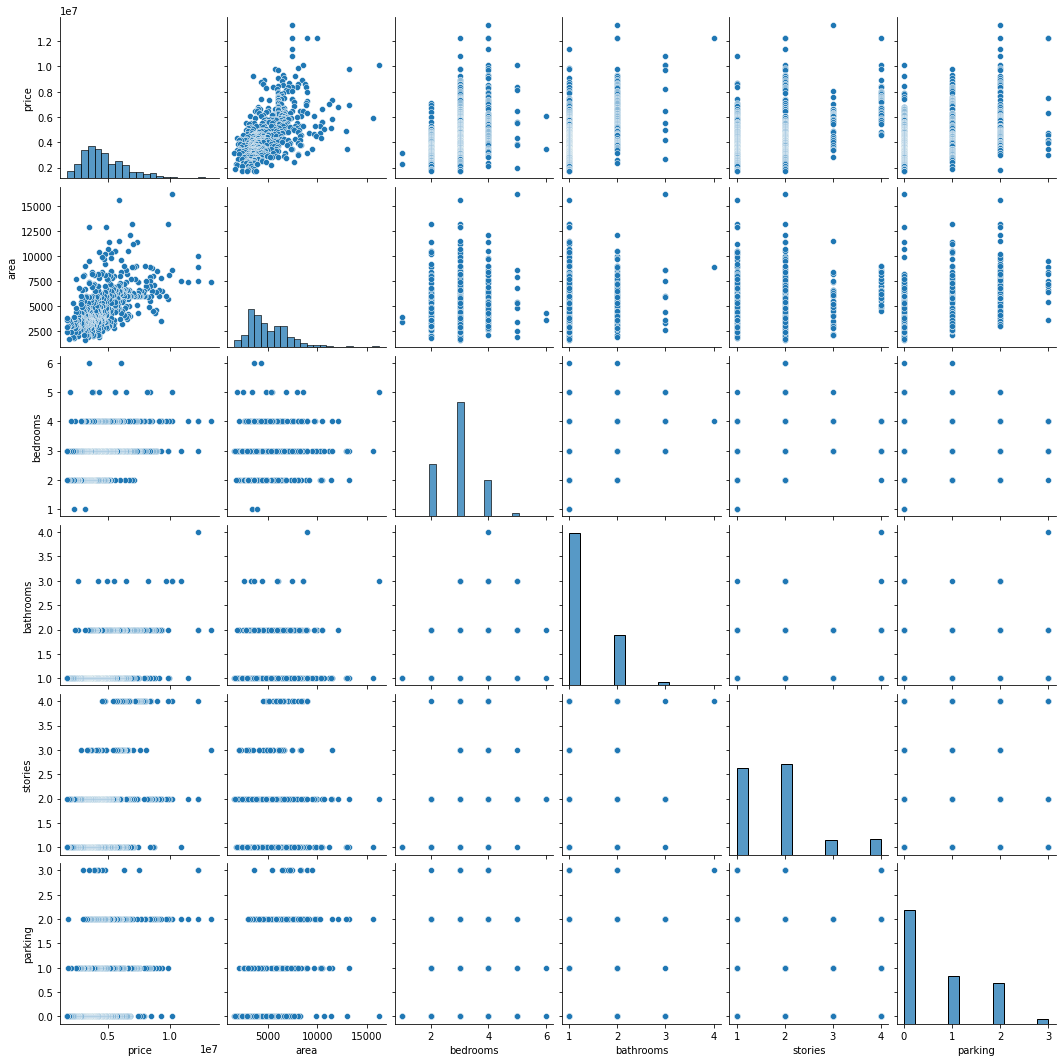

In [321]:
# Check the correlation between various numerical variables
sns.pairplot(housing)

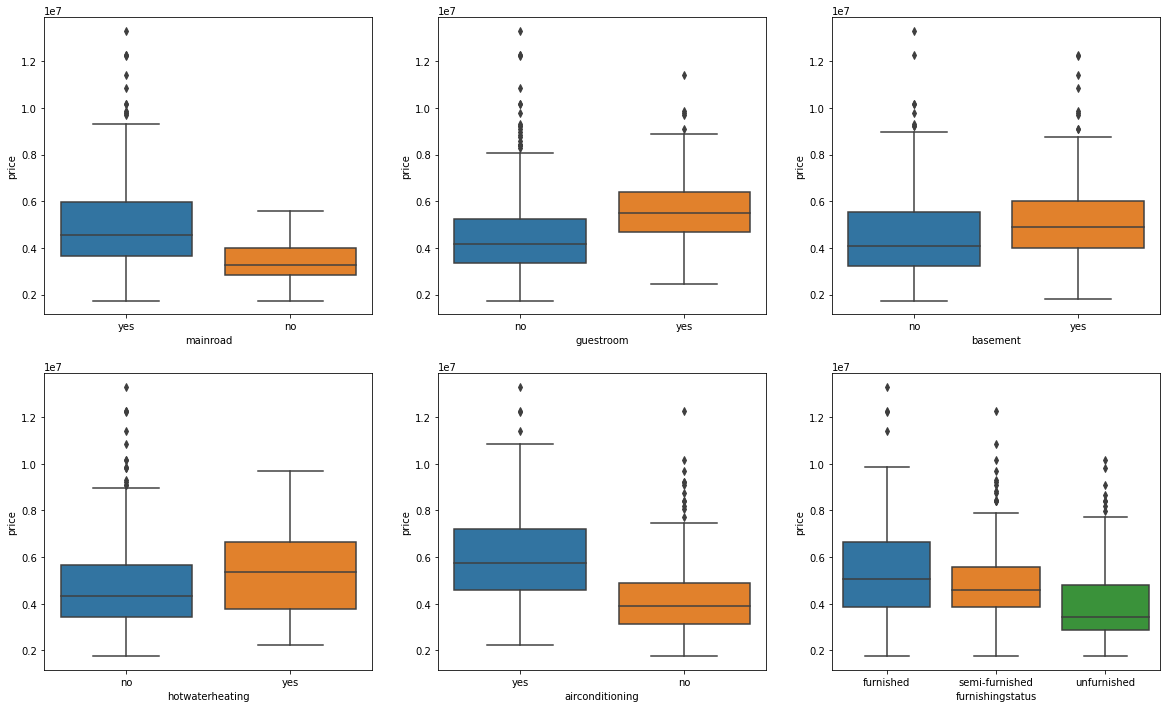

In [322]:
# Check the categorical variables
plt.figure(figsize=(20,12))

i = 1
for cat_var in ['mainroad', 'guestroom', 'basement', 'hotwaterheating','airconditioning','furnishingstatus']:
    plt.subplot(2, 3, i)
    sns.boxplot(x=cat_var, y='price', data=housing)
    i += 1

In [323]:
# Convert categorical variables to dummy
varlist = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning','prefarea']
for var in varlist:
    print(housing[var].value_counts())
    housing[var] = housing[var].apply(lambda x: 1 if x == 'yes' else 0)
    print(housing[var].value_counts())

yes    468
no      77
Name: mainroad, dtype: int64
1    468
0     77
Name: mainroad, dtype: int64
no     448
yes     97
Name: guestroom, dtype: int64
0    448
1     97
Name: guestroom, dtype: int64
no     354
yes    191
Name: basement, dtype: int64
0    354
1    191
Name: basement, dtype: int64
no     520
yes     25
Name: hotwaterheating, dtype: int64
0    520
1     25
Name: hotwaterheating, dtype: int64
no     373
yes    172
Name: airconditioning, dtype: int64
0    373
1    172
Name: airconditioning, dtype: int64
no     417
yes    128
Name: prefarea, dtype: int64
0    417
1    128
Name: prefarea, dtype: int64


## 3. Prepare the Data
- Convert categorical variables to dummies
- Scaling
- Split the data into train and test data sets

In [324]:
# Convert furnishingstatus categorical variable to dummy variable
print(housing['furnishingstatus'].value_counts())
status = pd.get_dummies(housing['furnishingstatus'],drop_first=True)
housing = pd.concat([housing, status], axis=1)
housing.drop(columns='furnishingstatus', inplace=True)
housing.head()

semi-furnished    227
unfurnished       178
furnished         140
Name: furnishingstatus, dtype: int64


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


In [325]:
# Split the dataset into train and test
df_train, df_test = train_test_split(housing, train_size=0.7, random_state=100)
print(df_train.shape, df_test.shape)

(381, 14) (164, 14)


In [363]:
# Rescaling
scaler = MinMaxScaler()

num_vars = ['area', 'bedrooms', 'bathrooms', 'stories','parking', 'price']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
print(df_train)

        price      area  bedrooms  bathrooms   stories  mainroad  guestroom  \
359  0.169697  0.155227       0.4        0.0  0.000000         1          0   
19   0.615152  0.403379       0.4        0.5  0.333333         1          0   
159  0.321212  0.115628       0.4        0.5  0.000000         1          1   
35   0.548133  0.454417       0.4        0.5  1.000000         1          0   
28   0.575758  0.538015       0.8        0.5  0.333333         1          0   
..        ...       ...       ...        ...       ...       ...        ...   
526  0.048485  0.118268       0.2        0.0  0.000000         1          0   
53   0.484848  0.291623       0.4        0.5  1.000000         1          0   
350  0.175758  0.139388       0.2        0.0  0.333333         1          0   
79   0.424242  0.366420       0.4        0.5  0.666667         1          1   
520  0.060606  0.516015       0.2        0.0  0.000000         1          0   

     basement  hotwaterheating  airconditioning   p

<AxesSubplot:>

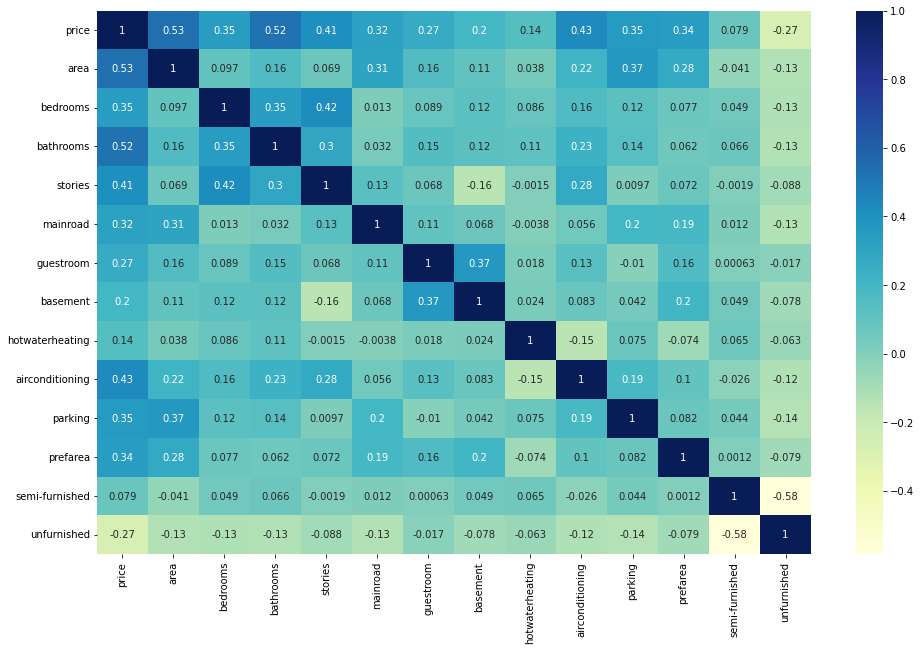

In [327]:
plt.figure(figsize=(16, 10))
sns.heatmap(df_train.corr(),annot=True, cmap='YlGnBu')

In [328]:
X_train = df_train.iloc[:,1:]
y_train = df_train[['price']]
print(X_train.head())
print(y_train.head())

         area  bedrooms  bathrooms   stories  mainroad  guestroom  basement  \
359  0.155227       0.4        0.0  0.000000         1          0         0   
19   0.403379       0.4        0.5  0.333333         1          0         0   
159  0.115628       0.4        0.5  0.000000         1          1         1   
35   0.454417       0.4        0.5  1.000000         1          0         0   
28   0.538015       0.8        0.5  0.333333         1          0         1   

     hotwaterheating  airconditioning   parking  prefarea  semi-furnished  \
359                0                0  0.333333         0               0   
19                 0                1  0.333333         1               1   
159                0                1  0.000000         0               0   
35                 0                1  0.666667         0               0   
28                 1                0  0.666667         0               0   

     unfurnished  
359            1  
19             0  
159  

## 4. Train the model - Adding one variable at a time

In [329]:
# Add one variable at a time and check
# - statistical significance of the variable
# - VIF - multicollinearity
lr_model, _ = buildModel(X_train['area'],y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     149.6
Date:                Sat, 28 Aug 2021   Prob (F-statistic):           3.15e-29
Time:                        21:10:51   Log-Likelihood:                 227.23
No. Observations:                 381   AIC:                            -450.5
Df Residuals:                     379   BIC:                            -442.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1269      0.013      9.853      0.0

In [330]:
# add another variable - bathrooms
lr_model, _ = buildModel(X_train[['area', 'bathrooms']],y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     174.1
Date:                Sat, 28 Aug 2021   Prob (F-statistic):           2.51e-54
Time:                        21:10:51   Log-Likelihood:                 288.24
No. Observations:                 381   AIC:                            -570.5
Df Residuals:                     378   BIC:                            -558.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1046      0.011      9.384      0.0

In [331]:
# add another variable - badrooms
lr_model, _ = buildModel(X_train[['area', 'bathrooms','bedrooms']],y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     128.2
Date:                Sat, 28 Aug 2021   Prob (F-statistic):           3.12e-57
Time:                        21:10:51   Log-Likelihood:                 297.76
No. Observations:                 381   AIC:                            -587.5
Df Residuals:                     377   BIC:                            -571.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0414      0.018      2.292      0.0

## 4. Train the model - Add all variables and drop one variable at a time
Algorithm
1. Build model
2. Look at p-values and VIF
    | | Desired/Retain| Remove |
    |---|---|---|
    | p-values | Low p-values/High significance < 0.05 | Low p-values: p-value > 0.05|
    | VIF | Low VIF VIF < 5  | High VIF: VIF > 5 |
3. Iterate:  Drop variables one by one and repeat 1, 2 & 3
    ||||
    |---|---|---|
    | 1 | High p-value, High VIF | Remove |
    | 2 | Low p-value, low VIF | Retain |
    | 3 | High p-value, Low VIF | Remove one at a time, build model|
    | 4 | Low p-value, High VIF | |

In [332]:
lr_model, _ = buildModel(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     60.40
Date:                Sat, 28 Aug 2021   Prob (F-statistic):           8.83e-83
Time:                        21:10:51   Log-Likelihood:                 381.79
No. Observations:                 381   AIC:                            -735.6
Df Residuals:                     367   BIC:                            -680.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0200      0.021     

In [333]:
getVIF(X_train)

           Features   VIF
1          bedrooms  7.33
4          mainroad  6.02
0              area  4.67
3           stories  2.70
11   semi-furnished  2.19
9           parking  2.12
6          basement  2.02
12      unfurnished  1.82
8   airconditioning  1.77
2         bathrooms  1.67
10         prefarea  1.51
5         guestroom  1.47
7   hotwaterheating  1.14


H



In [334]:
# semi-furnished has highest p-value 0.938, so let's drop it
print("X_train.shape", X_train.shape)
X = X_train.drop("semi-furnished", axis=1)
print("X.shape", X.shape)
lr_model, X_train_sm = buildModel(X, y_train)
print("X_train_sm.shape", X_train_sm.shape)

X_train.shape (381, 13)
X.shape (381, 12)
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     65.61
Date:                Sat, 28 Aug 2021   Prob (F-statistic):           1.07e-83
Time:                        21:10:51   Log-Likelihood:                 381.79
No. Observations:                 381   AIC:                            -737.6
Df Residuals:                     368   BIC:                            -686.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------


In [335]:
getVIF(X)

           Features   VIF
1          bedrooms  6.59
4          mainroad  5.68
0              area  4.67
3           stories  2.69
9           parking  2.12
6          basement  2.01
8   airconditioning  1.77
2         bathrooms  1.67
10         prefarea  1.51
5         guestroom  1.47
11      unfurnished  1.40
7   hotwaterheating  1.14


In [336]:
# bedrooms has the high p-value, so let's drop this
print("X_train.shape", X.shape)
X = X.drop("bedrooms", axis=1)
print("X.shape", X.shape)
lr_model, X_train_sm = buildModel(X, y_train)
print("X_train_sm", X_train_sm)

X_train.shape (381, 12)
X.shape (381, 11)
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     71.31
Date:                Sat, 28 Aug 2021   Prob (F-statistic):           2.73e-84
Time:                        21:10:51   Log-Likelihood:                 380.96
No. Observations:                 381   AIC:                            -737.9
Df Residuals:                     369   BIC:                            -690.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------


In [337]:
getVIF(X)

           Features   VIF
3          mainroad  4.79
0              area  4.55
2           stories  2.23
8           parking  2.10
5          basement  1.87
7   airconditioning  1.76
1         bathrooms  1.61
9          prefarea  1.50
4         guestroom  1.46
10      unfurnished  1.33
6   hotwaterheating  1.12


## Step 5. Residual Analysis

In [338]:
y_train_pred = lr_model.predict(X_train_sm)

In [339]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381 entries, 359 to 520
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   381 non-null    float64
dtypes: float64(1)
memory usage: 6.0 KB


In [340]:
print(type(y_train))
print(type(y_train_pred))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [341]:
print(y_train)
print(y_train_pred)

        price
359  0.169697
19   0.615152
159  0.321212
35   0.548133
28   0.575758
..        ...
526  0.048485
53   0.484848
350  0.175758
79   0.424242
520  0.060606

[381 rows x 1 columns]
359    0.109599
19     0.463835
159    0.330450
35     0.515631
28     0.468225
         ...   
526    0.079966
53     0.477416
350    0.263852
79     0.443907
520    0.173336
Length: 381, dtype: float64


In [342]:
res = (y_train['price'] - y_train_pred)
print(res)

359    0.060098
19     0.151316
159   -0.009238
35     0.032502
28     0.107532
         ...   
526   -0.031481
53     0.007433
350   -0.088094
79    -0.019664
520   -0.112730
Length: 381, dtype: float64


Text(0.5, 1.0, 'Residuals')

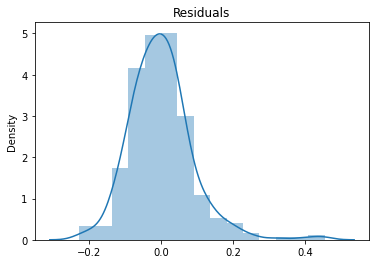

In [343]:
plt.figure()
sns.distplot(res, bins=15)
plt.title("Residuals")

## 6.Predictions

In [344]:
df_test[num_vars] = scaler.transform(df_test[num_vars]) # only transform not fit
print(df_test[num_vars])

         area  bedrooms  bathrooms   stories   parking     price
265  0.091869       0.4        0.0  0.333333  0.000000  0.229697
54   0.366420       0.4        0.5  0.333333  0.333333  0.484848
171  0.742080       0.4        0.0  0.000000  0.333333  0.303030
244  0.306582       0.4        0.0  0.333333  0.000000  0.242424
268  0.274023       0.6        0.0  0.333333  0.000000  0.227879
..        ...       ...        ...       ...       ...       ...
413  0.010032       0.4        0.5  0.333333  0.000000  0.145455
191  0.780007       0.4        0.0  0.333333  0.000000  0.284848
310  0.365100       0.4        0.0  0.000000  0.000000  0.206061
46   0.366420       0.4        0.5  1.000000  0.333333  0.500000
50   0.493136       0.4        0.5  1.000000  0.333333  0.490909

[164 rows x 6 columns]


In [345]:
df_test.describe()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,0.263176,0.298548,0.408537,0.158537,0.268293,0.865854,0.195122,0.347561,0.030488,0.353659,0.205285,0.237805,0.420732,0.329268
std,0.172077,0.211922,0.147537,0.281081,0.276007,0.341853,0.397508,0.477654,0.172452,0.479569,0.289322,0.427043,0.495189,0.471387
min,0.006061,-0.016367,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142424,0.148011,0.400000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.226061,0.259724,0.400000,0.000000,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.346970,0.397439,0.400000,0.500000,0.333333,1.000000,0.000000,1.000000,0.000000,1.000000,0.333333,0.000000,1.000000,1.000000
max,0.909091,1.263992,0.800000,1.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [347]:
y_test = df_test.pop('price')
X_test = df_test

In [348]:
X_test_sm = sm.add_constant(X_test)
X_test_sm.head()

,const,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
265,1.0,0.091869,0.4,0.0,0.333333,1,0,0,0,0,0.000000,1,1,0
54,1.0,0.366420,0.4,0.5,0.333333,1,1,0,0,1,0.333333,0,1,0
171,1.0,0.742080,0.4,0.0,0.000000,1,0,0,0,0,0.333333,1,1,0
244,1.0,0.306582,0.4,0.0,0.333333,1,1,1,0,0,0.000000,1,1,0
268,1.0,0.274023,0.6,0.0,0.333333,1,0,0,0,1,0.000000,0,1,0


In [349]:
X_test_sm.drop(columns=['semi-furnished', 'bedrooms'],inplace=True)

In [353]:
y_test_pred = lr_model.predict(X_test_sm)

In [354]:
r2_score(y_true=y_test, y_pred = y_test_pred)

0.6713505684480789

We can see that the equation of our best fitted line is:

$ price = 0.236  \times  area + 0.202  \times  bathrooms + 0.11 \times stories + 0.05 \times mainroad + 0.04 \times guestroom + 0.0876 \times hotwaterheating + 0.0682 \times airconditioning + 0.0629 \times parking + 0.0637 \times prefarea - 0.0337 \times unfurnished $

## 7. RFE - Recrusive Feature Elimination

In [356]:
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


In [362]:
print(type(df_train), df_train.shape)
print(type(df_test), df_test.shape)

<class 'pandas.core.frame.DataFrame'> (381, 14)
<class 'pandas.core.frame.DataFrame'> (164, 13)


In [365]:
print(type(X_train), X_train.shape)
print(type(y_train), y_train.shape)

<class 'pandas.core.frame.DataFrame'> (381, 13)
<class 'pandas.core.frame.DataFrame'> (381, 1)


In [367]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [368]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 10)
rfe = rfe.fit(X_train,y_train)

In [369]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('area', True, 1),
 ('bedrooms', True, 1),
 ('bathrooms', True, 1),
 ('stories', True, 1),
 ('mainroad', True, 1),
 ('guestroom', True, 1),
 ('basement', False, 3),
 ('hotwaterheating', True, 1),
 ('airconditioning', True, 1),
 ('parking', True, 1),
 ('prefarea', True, 1),
 ('semi-furnished', False, 4),
 ('unfurnished', False, 2)]

In [370]:
col = X_train.columns[rfe.support_]
col

Index(['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom',
       'hotwaterheating', 'airconditioning', 'parking', 'prefarea'],
      dtype='object')

In [371]:
X_train.columns[~rfe.support_]

Index(['basement', 'semi-furnished', 'unfurnished'], dtype='object')

In [373]:
X_train_rfe = X_train[col]
lm, _ = buildModel(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     74.89
Date:                Sun, 29 Aug 2021   Prob (F-statistic):           1.28e-82
Time:                        10:07:28   Log-Likelihood:                 374.65
No. Observations:                 381   AIC:                            -727.3
Df Residuals:                     370   BIC:                            -683.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0027      0.018     

In [374]:
X_train_new = X_train_rfe.drop(['bedrooms'], axis=1)

In [378]:
lm, X_train_lm = buildModel(X_train_new, y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     82.37
Date:                Sun, 29 Aug 2021   Prob (F-statistic):           6.67e-83
Time:                        10:25:48   Log-Likelihood:                 373.00
No. Observations:                 381   AIC:                            -726.0
Df Residuals:                     371   BIC:                            -686.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0242      0.013     

In [379]:
getVIF(X_train_new)

          Features   VIF
0             area  4.52
3         mainroad  4.26
2          stories  2.12
7          parking  2.10
6  airconditioning  1.75
1        bathrooms  1.58
8         prefarea  1.47
4        guestroom  1.30
5  hotwaterheating  1.12


<AxesSubplot:ylabel='Density'>

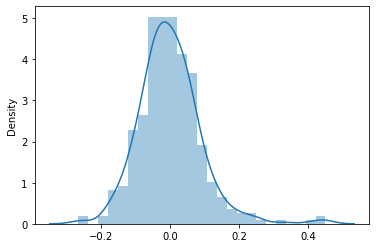

In [382]:
y_train_pred = lm.predict(X_train_lm)
res = (y_train['price'] - y_train_pred)
plt.figure()
sns.distplot(res)

Centered around 0

In [393]:
X_test_new = X_test[X_train_new.columns]
X_test_new = sm.add_constant(X_test_new)
X_test_new.head()

,const,area,bathrooms,stories,mainroad,guestroom,hotwaterheating,airconditioning,parking,prefarea
265,1.0,0.091869,0.0,0.333333,1,0,0,0,0.000000,1
54,1.0,0.366420,0.5,0.333333,1,1,0,1,0.333333,0
171,1.0,0.742080,0.0,0.000000,1,0,0,0,0.333333,1
244,1.0,0.306582,0.0,0.333333,1,1,0,0,0.000000,1
268,1.0,0.274023,0.0,0.333333,1,0,0,1,0.000000,0


In [394]:
len(X_train_new.columns)

9

In [396]:
X_train_new.head()

,area,bathrooms,stories,mainroad,guestroom,hotwaterheating,airconditioning,parking,prefarea
359,0.155227,0.0,0.000000,1,0,0,0,0.333333,0
19,0.403379,0.5,0.333333,1,0,0,1,0.333333,1
159,0.115628,0.5,0.000000,1,1,0,1,0.000000,0
35,0.454417,0.5,1.000000,1,0,0,1,0.666667,0
28,0.538015,0.5,0.333333,1,0,1,0,0.666667,0


In [395]:
len(X_test_new.columns)

10

In [398]:
y_test_pred = lm.predict(X_test_new)

In [401]:
print(type(y_test))

<class 'pandas.core.series.Series'>


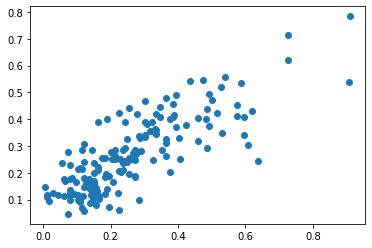

In [403]:
plt.figure()
plt.scatter(y_test, y_test_pred)

<AxesSubplot:ylabel='Density'>

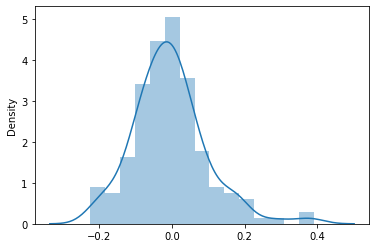

In [402]:
res = (y_test - y_test_pred)
plt.figure()
sns.distplot(res)